In [21]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

compat_rename = {'Ultimate Tensile Strength': 'Tensile Strength, Ultimate',
                 'Yield Strength': 'Tensile Strength, Yield',
                 'Elongation': 'Elongation at Break',
                 'names': 'Name'}

In [22]:
nickel_data = pd.read_csv("full_set.csv", index_col=0)
# nickel_data = nickel_data.drop(columns="Name")
nickel_data = nickel_data.rename(columns=compat_rename)
nickel_data.head()

,Name,"Tensile Strength, Yield",Pressure treated,Area under heat treatment curve,Strengthening Precipitate Phase,Powder processed,Al,B,C,Co,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,Allvac718PLUS,989.0,No,392890.0,GammaPrime,No,1.5,0.005,0.020,9.1,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,HastelloyS,NaN,No,0.0,NaN,No,0.3,0.000,0.000,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,Haynes230,NaN,No,0.0,NaN,No,0.3,0.000,0.100,0.0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,Waspaloy,NaN,No,19572.0,NaN,No,1.3,0.001,0.035,13.4,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Unnamedalloy10,NaN,No,0.0,NaN,No,5.7,0.000,0.000,15.0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train for UTS

In [23]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

UTS_data = hf.clean_dataframe(nickel_data, "Tensile Strength, Ultimate")
UTS_data.head()

,Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,La,...,Zr,"Tensile Strength, Ultimate",Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
1,0.0,0.30,0.000,0.000,0.0,15.5,0.0,1.00,0.0,0.0,...,0.0,845.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.46,0.003,0.031,0.0,18.0,0.0,18.25,0.0,0.0,...,0.0,1261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,6.10,0.012,0.120,0.0,12.5,0.0,0.00,0.0,0.0,...,0.1,870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,41520.0,3.87,0.020,0.015,16.9,14.8,0.0,0.40,0.0,0.0,...,0.0,1466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,15205.0,5.40,0.000,0.008,35.0,3.3,0.0,25.00,0.0,0.0,...,0.0,816.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:

UTS_train_data = UTS_data.sample(frac=0.8, random_state=2222)
UTS_test_data = UTS_data.drop(UTS_train_data.index)

UTS_data.head()

,Area under heat treatment curve,Al,B,C,Co,Cr,Cu,Fe,Hf,La,...,Zr,"Tensile Strength, Ultimate",Pressure treated_Yes,Strengthening Precipitate Phase_Both,Strengthening Precipitate Phase_DoublePrime,Strengthening Precipitate Phase_GammaPrime,Strengthening Precipitate Phase_Solution,Strengthening Precipitate Phase_YprimeandEta,Strengthening Precipitate Phase_yprime+ODS,Powder processed_Yes
1,0.0,0.30,0.000,0.000,0.0,15.5,0.0,1.00,0.0,0.0,...,0.0,845.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.46,0.003,0.031,0.0,18.0,0.0,18.25,0.0,0.0,...,0.0,1261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,6.10,0.012,0.120,0.0,12.5,0.0,0.00,0.0,0.0,...,0.1,870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,41520.0,3.87,0.020,0.015,16.9,14.8,0.0,0.40,0.0,0.0,...,0.0,1466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,15205.0,5.40,0.000,0.008,35.0,3.3,0.0,25.00,0.0,0.0,...,0.0,816.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
UTS_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Area under heat treatment curve,718.0,48650.535156,183204.000000,0.0,5752.000000,13840.000,27526.000000,1.743038e+06
Al,718.0,2.482855,1.943765,0.0,0.560000,2.470,4.000000,6.300000e+00
B,718.0,0.011572,0.015833,0.0,0.001000,0.009,0.015000,1.600000e-01
C,718.0,0.062260,0.045277,0.0,0.030000,0.050,0.080000,1.800000e-01
Co,718.0,8.503427,7.737341,0.0,0.000000,9.500,14.750000,3.500000e+01
Cr,718.0,15.575013,4.710784,0.0,13.630000,16.000,18.610001,2.950000e+01
Cu,718.0,0.000573,0.001833,0.0,0.000000,0.000,0.000000,1.400000e-02
Fe,718.0,7.196393,11.812247,0.0,0.000000,0.000,17.830000,4.522000e+01
Hf,718.0,0.005571,0.105482,0.0,0.000000,0.000,0.000000,2.000000e+00
La,718.0,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.000000e+00


In [26]:
UTS_train_features = UTS_train_data.copy()
UTS_test_features = UTS_test_data.copy()

UTS_train_labels = UTS_train_features.pop("Tensile Strength, Ultimate")
UTS_test_labels = UTS_test_features.pop("Tensile Strength, Ultimate")

In [27]:
UTS_normalizer = hf.normalize(UTS_train_features)

First example: [[24006.       2.5      0.02     0.03    14.75    16.       0.       0.
      0.       0.       0.       0.       3.       0.       0.      57.41
      0.       0.       0.       0.       0.       5.       0.       1.25
      0.       0.       0.       0.07     0.       0.       0.       0.
      0.       0.       0.       0.  ]]

Normalized: [[-0.13  0.01  0.53 -0.82  0.81  0.09 -0.31 -0.61 -0.05  0.   -0.1  -0.36
  -0.14 -0.12 -0.77  0.09 -0.3   0.    0.   -0.51 -0.42  1.7  -0.18 -0.05
   0.    0.    0.    0.71  0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [28]:
def builder(hp): return hf.model_builder_variable(hp,
                                                  UTS_normalizer,
                                                  test_layers=[1,2,3],
                                                  dropout=0.5,
                                                  layer_1_nodes=[50,100,150,200,250],
                                                  layer_2_nodes=[50,100,150,200,250],
                                                  layer_3_nodes=[50,100,150,200,250])

In [29]:
# tuner = kt.RandomSearch(builder,
#                      objective='val_loss',
#                      max_trials=100,
#                      overwrite=True,
#                      directory='model_search',
#                      project_name='yield_model')

tuner = kt.Hyperband(builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     overwrite=True,
                     directory='model_search',
                     project_name='UTS_model')

tuner_es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [30]:
# tuner.search_space_summary(extended=True)

In [31]:
# tuner.search(UTS_train_features, UTS_train_labels, epochs=200, validation_split=0.2, callbacks=[tuner_es], verbose=2)


In [32]:
# tuner.results_summary()

In [33]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [34]:
# best_hps.get_config()['values']

In [35]:
# UTS_model = tuner.hypermodel.build(best_hps)

# UTS_model.summary()

In [36]:
# es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# history = UTS_model.fit(UTS_train_features, UTS_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=0)

# history = UTS_model.fit(UTS_train_features, UTS_train_labels, epochs=10000, validation_split=0.2, verbose=0)

In [37]:
# UTS_model.compile(loss='mean_squared_error',
#                     optimizer=tf.keras.optimizers.Nadam(0.001),
#                     metrics=[tf.keras.metrics.RootMeanSquaredError()])

# UTS_model.save("models/UTS_model")

# UTS_model.compile(loss='mean_squared_error',
#                     optimizer=tf.keras.optimizers.Nadam(0.001),
#                     metrics=[tf.keras.metrics.RootMeanSquaredError(),
#                             tf.keras.losses.MeanAbsoluteError()])

In [38]:
# UTS_model.evaluate(UTS_test_features, UTS_test_labels, verbose=1)

In [39]:
# hf.plot_loss(history)

6/6 [==============================] - 0s 998us/step


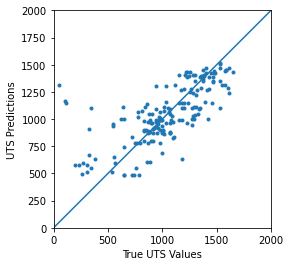

In [40]:
UTS_model = tf.keras.models.load_model("models/UTS_model")

test_predictions = UTS_model.predict(UTS_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(UTS_test_labels, test_predictions, marker=".")
plt.xlabel('True UTS Values')
plt.ylabel('UTS Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig("pictures/UTS_model_model.pdf", bbox_inches='tight')